In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# CNN1 - LSTM1

In [19]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))


model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 dropout (Dropout)           (None, 126, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                        

In [20]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 15s 36ms/step - loss: 1.0139 - accuracy: 0.4752 - val_loss: 0.8059 - val_accuracy: 0.7221
Epoch 2/10
26/26 [==============================] - 0s 11ms/step - loss: 0.6031 - accuracy: 0.7671 - val_loss: 0.4749 - val_accuracy: 0.7961
Epoch 3/10
26/26 [==============================] - 0s 10ms/step - loss: 0.2864 - accuracy: 0.9062 - val_loss: 0.3683 - val_accuracy: 0.8448
Epoch 4/10
26/26 [==============================] - 0s 9ms/step - loss: 0.1616 - accuracy: 0.9504 - val_loss: 0.1214 - val_accuracy: 0.9757
Epoch 5/10
26/26 [==============================] - 0s 9ms/step - loss: 0.1010 - accuracy: 0.9699 - val_loss: 0.0785 - val_accuracy: 0.9909
Epoch 6/10
26/26 [==============================] - 0s 11ms/step - loss: 0.0635 - accuracy: 0.9796 - val_loss: 0.0908 - val_accuracy: 0.9746
Epoch 7/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0639 - accuracy: 0.9790 - val_loss: 0.0423 - val_accuracy: 0.9888
Epoch 8/10
26/2

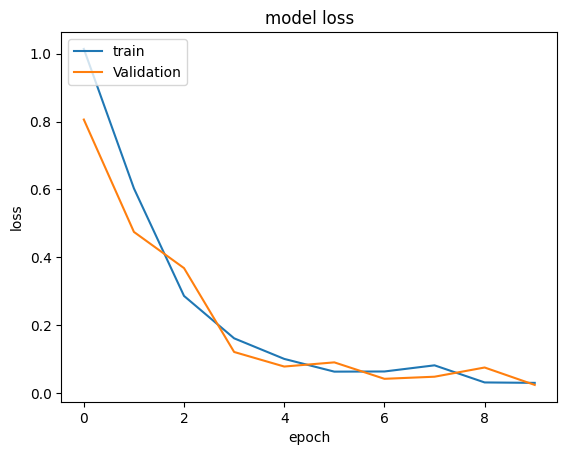

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

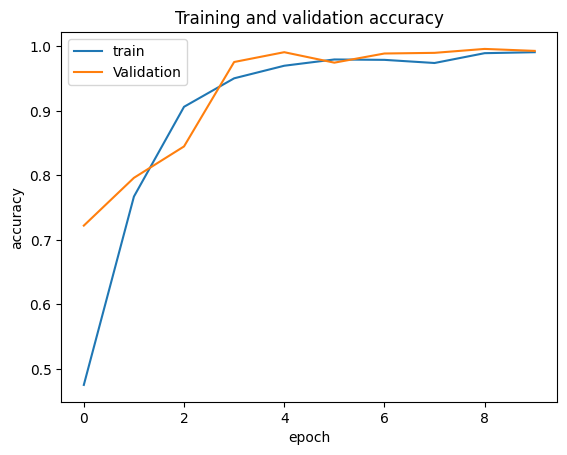

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
[[479   0  17]
 [ 32 421  18]
 [ 39   5 376]]
0.9199711607786589
0.9203057779524946
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       496
           1       0.99      0.89      0.94       471
           2       0.91      0.90      0.90       420

    accuracy                           0.92      1387
   macro avg       0.92      0.92      0.92      1387
weighted avg       0.92      0.92      0.92      1387



<Axes: >

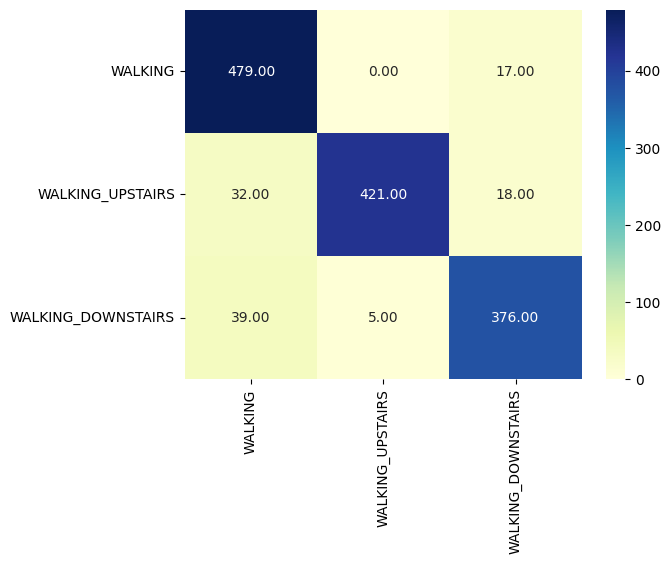

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer 3

# CNN 1 - LSTM2



In [24]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_2 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 63, 100)           66000     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

In [25]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 16s 96ms/step - loss: 0.9974 - accuracy: 0.4761 - val_loss: 0.7694 - val_accuracy: 0.6927
Epoch 2/10
26/26 [==============================] - 1s 24ms/step - loss: 0.5600 - accuracy: 0.7851 - val_loss: 0.3503 - val_accuracy: 0.8834
Epoch 3/10
26/26 [==============================] - 0s 18ms/step - loss: 0.2882 - accuracy: 0.9090 - val_loss: 0.1706 - val_accuracy: 0.9736
Epoch 4/10
26/26 [==============================] - 1s 21ms/step - loss: 0.1462 - accuracy: 0.9565 - val_loss: 0.1345 - val_accuracy: 0.9594
Epoch 5/10
26/26 [==============================] - 1s 28ms/step - loss: 0.1434 - accuracy: 0.9556 - val_loss: 0.0805 - val_accuracy: 0.9787
Epoch 6/10
26/26 [==============================] - 1s 22ms/step - loss: 0.0705 - accuracy: 0.9756 - val_loss: 0.1146 - val_accuracy: 0.9574
Epoch 7/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0576 - accuracy: 0.9799 - val_loss: 0.0346 - val_accuracy: 0.9868
Epoch 8/10
2

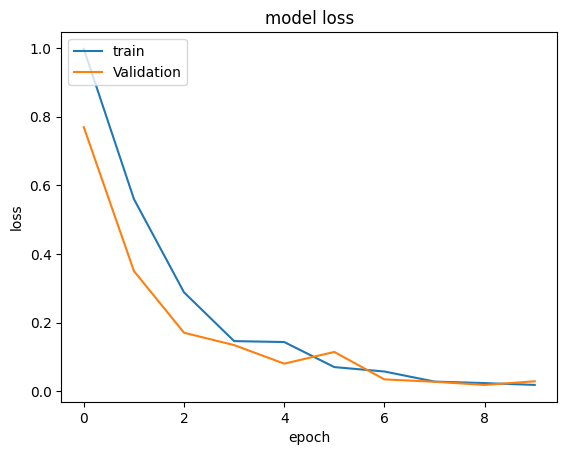

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

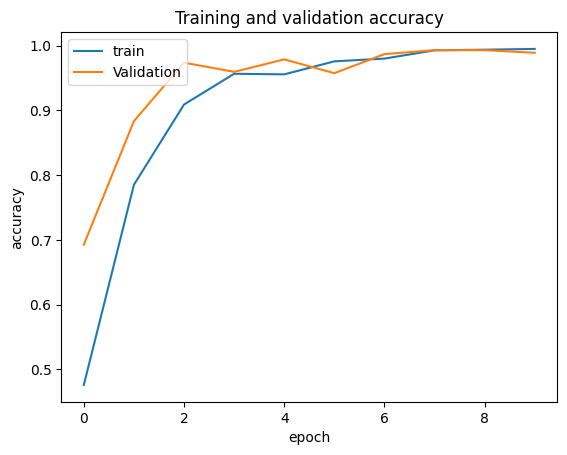

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 6ms/step
[[471   4  21]
 [  9 438  24]
 [ 52  11 357]]
0.912761355443403
0.9126574061690831
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       496
           1       0.97      0.93      0.95       471
           2       0.89      0.85      0.87       420

    accuracy                           0.91      1387
   macro avg       0.91      0.91      0.91      1387
weighted avg       0.91      0.91      0.91      1387



<Axes: >

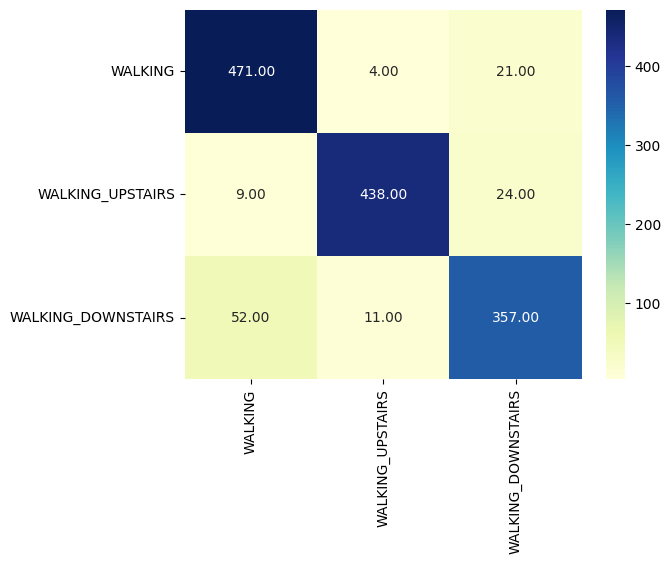

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [34]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_5 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_6 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                      

In [35]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 4s 40ms/step - loss: 0.9928 - accuracy: 0.4852 - val_loss: 0.8063 - val_accuracy: 0.7252
Epoch 2/10
26/26 [==============================] - 0s 12ms/step - loss: 0.5692 - accuracy: 0.7750 - val_loss: 0.4320 - val_accuracy: 0.8174
Epoch 3/10
26/26 [==============================] - 0s 10ms/step - loss: 0.2593 - accuracy: 0.9151 - val_loss: 0.1813 - val_accuracy: 0.9645
Epoch 4/10
26/26 [==============================] - 0s 11ms/step - loss: 0.1158 - accuracy: 0.9656 - val_loss: 0.0454 - val_accuracy: 0.9909
Epoch 5/10
26/26 [==============================] - 0s 9ms/step - loss: 0.1013 - accuracy: 0.9711 - val_loss: 0.1025 - val_accuracy: 0.9868
Epoch 6/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0562 - accuracy: 0.9854 - val_loss: 0.0371 - val_accuracy: 0.9949
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0568 - accuracy: 0.9836 - val_loss: 0.0922 - val_accuracy: 0.9726
Epoch 8/10
26/

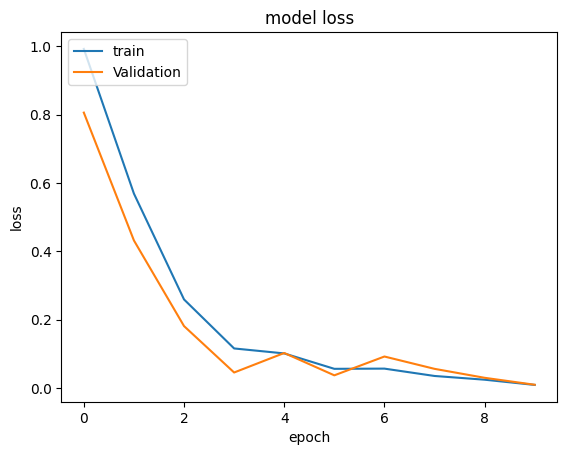

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

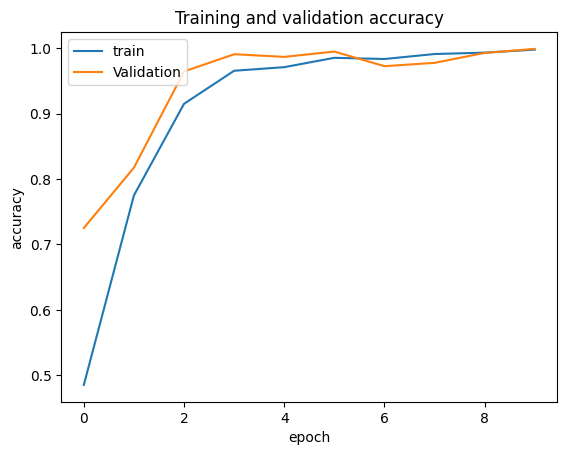

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 5ms/step
[[487   0   9]
 [ 36 409  26]
 [  6   9 405]]
0.9379956741167988
0.9374808565331374
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       496
           1       0.98      0.87      0.92       471
           2       0.92      0.96      0.94       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

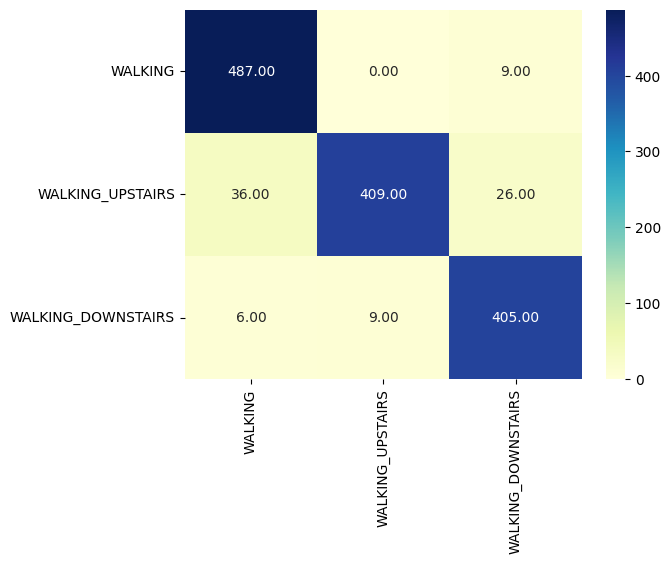

In [38]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer4

# CNN1 - LSTM3

In [39]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_8 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 63, 100)           66000     
                                                                 
 lstm_6 (LSTM)               (None, 63, 100)           80400     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                      

In [40]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 10s 62ms/step - loss: 0.9363 - accuracy: 0.5452 - val_loss: 0.6840 - val_accuracy: 0.7069
Epoch 2/10
26/26 [==============================] - 0s 17ms/step - loss: 0.4859 - accuracy: 0.8204 - val_loss: 0.2552 - val_accuracy: 0.9280
Epoch 3/10
26/26 [==============================] - 0s 18ms/step - loss: 0.2953 - accuracy: 0.9023 - val_loss: 0.1570 - val_accuracy: 0.9615
Epoch 4/10
26/26 [==============================] - 0s 17ms/step - loss: 0.1353 - accuracy: 0.9571 - val_loss: 0.1151 - val_accuracy: 0.9696
Epoch 5/10
26/26 [==============================] - 1s 21ms/step - loss: 0.0852 - accuracy: 0.9735 - val_loss: 0.0679 - val_accuracy: 0.9777
Epoch 6/10
26/26 [==============================] - 1s 24ms/step - loss: 0.0560 - accuracy: 0.9811 - val_loss: 0.0424 - val_accuracy: 0.9888
Epoch 7/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0538 - accuracy: 0.9845 - val_loss: 0.0541 - val_accuracy: 0.9919
Epoch 8/10
2

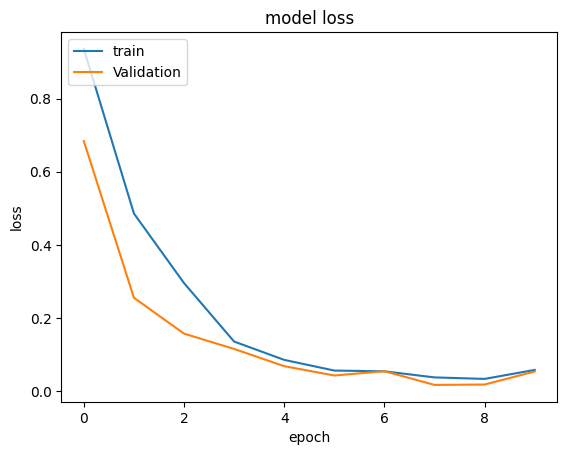

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

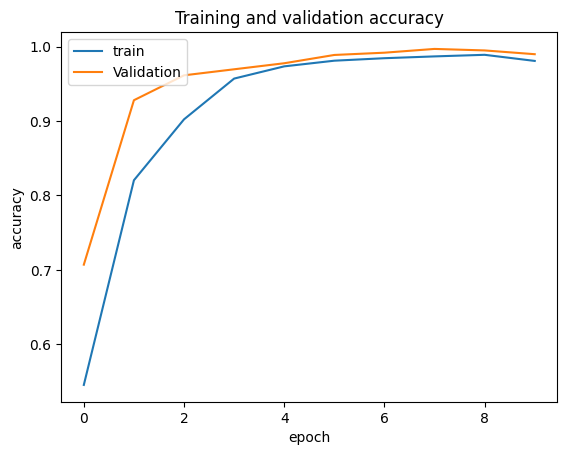

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 8ms/step
[[463   6  27]
 [ 11 440  20]
 [ 32  15 373]]
0.9199711607786589
0.9200434546214019
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       496
           1       0.95      0.93      0.94       471
           2       0.89      0.89      0.89       420

    accuracy                           0.92      1387
   macro avg       0.92      0.92      0.92      1387
weighted avg       0.92      0.92      0.92      1387



<Axes: >

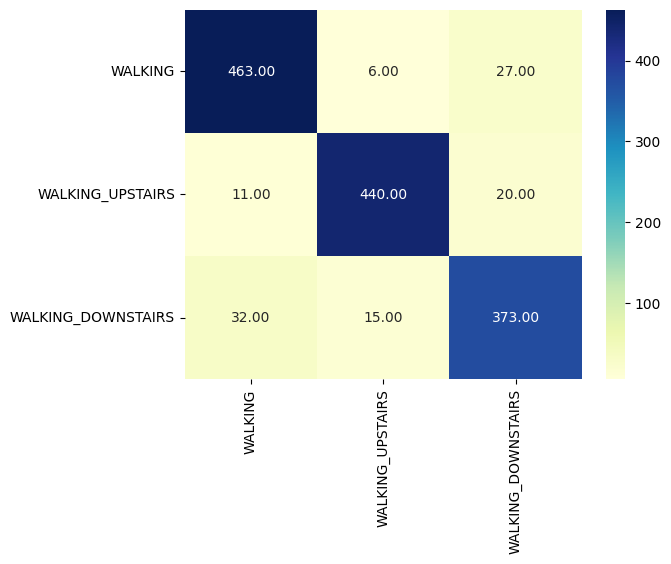

In [43]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [44]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_8 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_10 (Dropout)        (None, 124, 64)           0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 62, 100)           66000     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                      

In [45]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 5s 50ms/step - loss: 0.9582 - accuracy: 0.5044 - val_loss: 0.5756 - val_accuracy: 0.7819
Epoch 2/10
26/26 [==============================] - 0s 14ms/step - loss: 0.4100 - accuracy: 0.8466 - val_loss: 0.2819 - val_accuracy: 0.8895
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: 0.1809 - accuracy: 0.9403 - val_loss: 0.1040 - val_accuracy: 0.9726
Epoch 4/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0771 - accuracy: 0.9760 - val_loss: 0.0470 - val_accuracy: 0.9878
Epoch 5/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0627 - accuracy: 0.9799 - val_loss: 0.0708 - val_accuracy: 0.9797
Epoch 6/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0581 - accuracy: 0.9823 - val_loss: 0.0876 - val_accuracy: 0.9838
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0801 - accuracy: 0.9729 - val_loss: 0.0161 - val_accuracy: 0.9949
Epoch 8/10
26

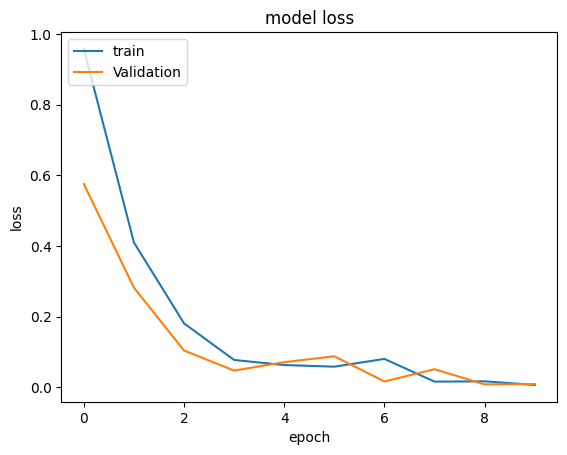

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

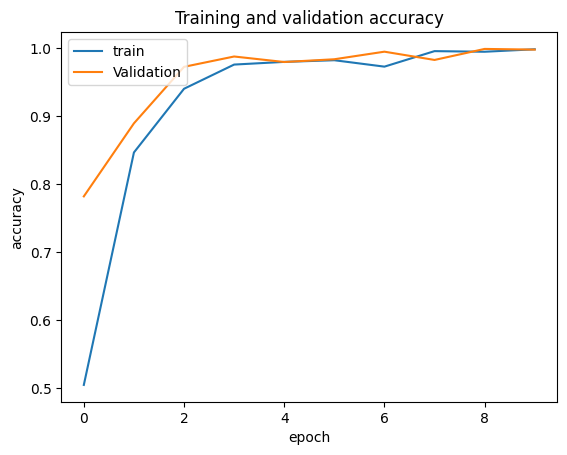

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 6ms/step
[[464   7  25]
 [  1 443  27]
 [  5   3 412]]
0.9509733237202596
0.9514143443662526
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.98      0.94      0.96       471
           2       0.89      0.98      0.93       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

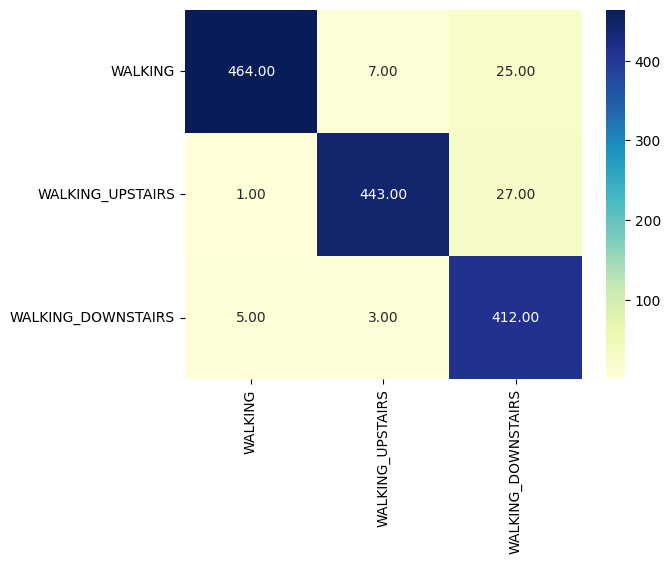

In [48]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM1

In [49]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_10 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_12 (Dropout)        (None, 124, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 60, 64)            12352     
                                                                 
 dropout_13 (Dropout)        (None, 60, 64)            0         
                                                      

In [50]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 48ms/step - loss: 0.9121 - accuracy: 0.5300 - val_loss: 0.6720 - val_accuracy: 0.7698
Epoch 2/10
26/26 [==============================] - 0s 12ms/step - loss: 0.4893 - accuracy: 0.8076 - val_loss: 0.3907 - val_accuracy: 0.9067
Epoch 3/10
26/26 [==============================] - 0s 12ms/step - loss: 0.2017 - accuracy: 0.9349 - val_loss: 0.1596 - val_accuracy: 0.9817
Epoch 4/10
26/26 [==============================] - 0s 11ms/step - loss: 0.1283 - accuracy: 0.9565 - val_loss: 0.0990 - val_accuracy: 0.9848
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.0567 - accuracy: 0.9814 - val_loss: 0.0744 - val_accuracy: 0.9899
Epoch 6/10
26/26 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9857 - val_loss: 0.0517 - val_accuracy: 0.9878
Epoch 7/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0283 - accuracy: 0.9896 - val_loss: 0.0456 - val_accuracy: 0.9929
Epoch 8/10
26

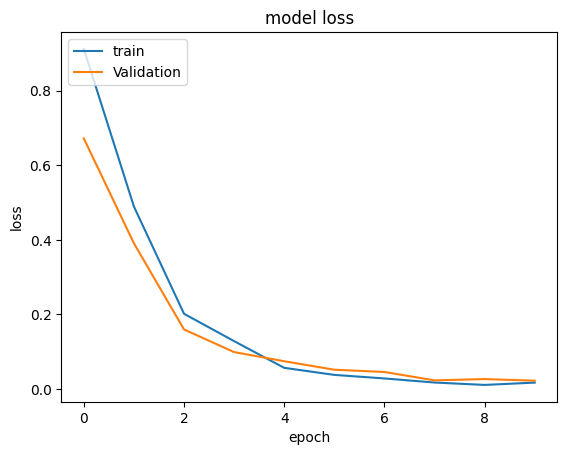

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

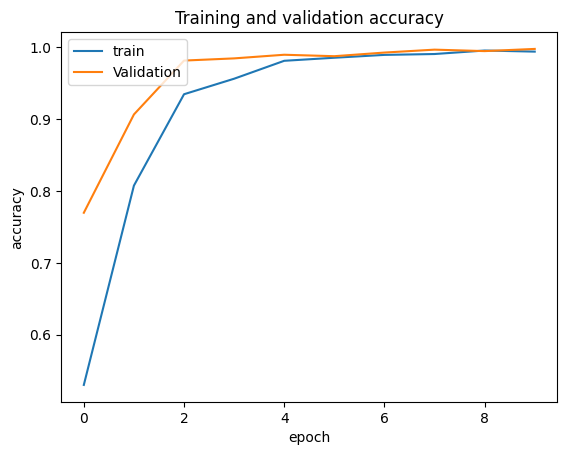

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 4ms/step
[[471  25   0]
 [  5 443  23]
 [ 10  16 394]]
0.943042537851478
0.9431709833453509
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.92      0.94      0.93       471
           2       0.94      0.94      0.94       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

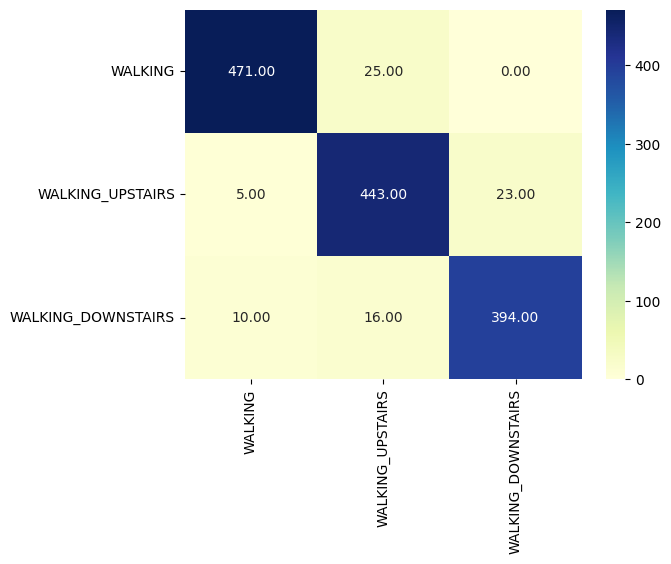

In [53]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer5

# CNN

# C4 L1

In [54]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 conv1d_13 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_15 (Dropout)        (None, 124, 64)           0         
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 60, 64)            12352     
                                                                 
 conv1d_15 (Conv1D)          (None, 58, 64)            12352     
                                                      

In [55]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 8s 52ms/step - loss: 1.0194 - accuracy: 0.4463 - val_loss: 0.8424 - val_accuracy: 0.6521
Epoch 2/10
26/26 [==============================] - 0s 15ms/step - loss: 0.5627 - accuracy: 0.7778 - val_loss: 0.4097 - val_accuracy: 0.8682
Epoch 3/10
26/26 [==============================] - 0s 15ms/step - loss: 0.1867 - accuracy: 0.9440 - val_loss: 0.2687 - val_accuracy: 0.9209
Epoch 4/10
26/26 [==============================] - 0s 16ms/step - loss: 0.0956 - accuracy: 0.9732 - val_loss: 0.0741 - val_accuracy: 0.9929
Epoch 5/10
26/26 [==============================] - 0s 16ms/step - loss: 0.0435 - accuracy: 0.9875 - val_loss: 0.0358 - val_accuracy: 0.9949
Epoch 6/10
26/26 [==============================] - 0s 16ms/step - loss: 0.0410 - accuracy: 0.9887 - val_loss: 0.0647 - val_accuracy: 0.9817
Epoch 7/10
26/26 [==============================] - 0s 16ms/step - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.0209 - val_accuracy: 0.9980
Epoch 8/10
26

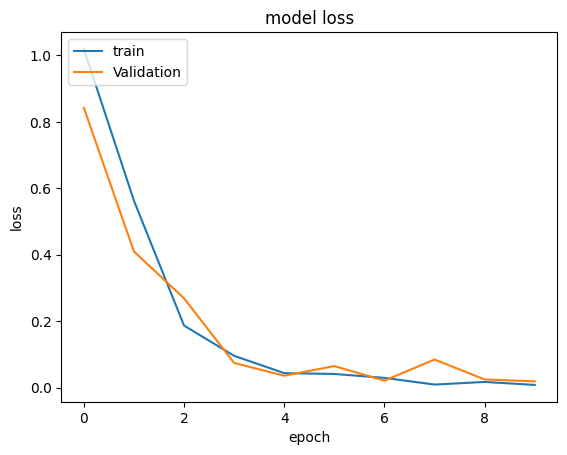

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

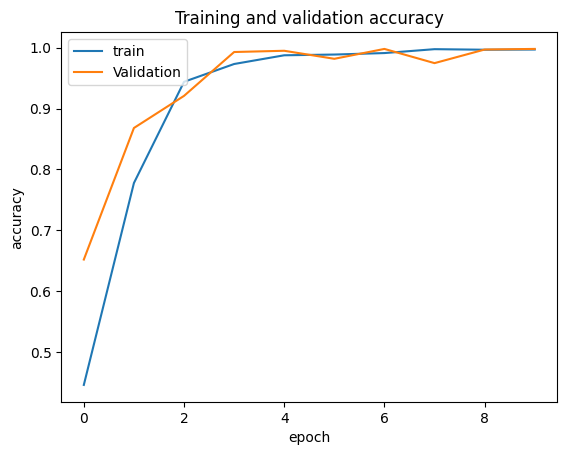

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 6ms/step
[[496   0   0]
 [ 10 445  16]
 [ 49  16 355]]
0.9343907714491708
0.9336134610086203
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       496
           1       0.97      0.94      0.95       471
           2       0.96      0.85      0.90       420

    accuracy                           0.93      1387
   macro avg       0.94      0.93      0.93      1387
weighted avg       0.94      0.93      0.93      1387



<Axes: >

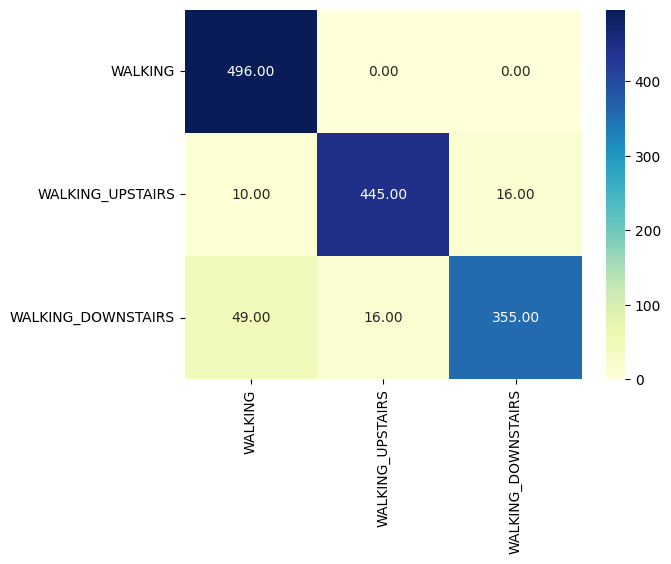

In [58]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')



# Timedistributed

In [ ]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(4067, 4, 32, 9) (1560, 4, 32, 9)


In [ ]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm_23 (LSTM)              (None, 100)             

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 28ms/step - loss: 0.3756 - accuracy: 0.8439 - val_loss: 0.2086 - val_accuracy: 0.8960
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2147 - accuracy: 0.9075 - val_loss: 0.2024 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2019 - accuracy: 0.9125 - val_loss: 0.1990 - val_accuracy: 0.9271
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.9181 - val_loss: 0.2068 - val_accuracy: 0.8976
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1929 - accuracy: 0.9176 - val_loss: 0.1876 - val_accuracy: 0.9279
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1924 - accuracy: 0.9130 - val_loss: 0.1942 - val_accuracy: 0.9255
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.9216 - val_loss: 0.1946 - val_accuracy: 0.9075
Epoch 8/10
32/32 [=

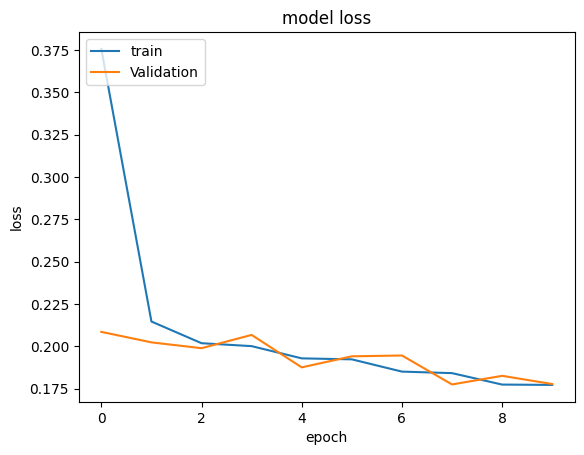

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

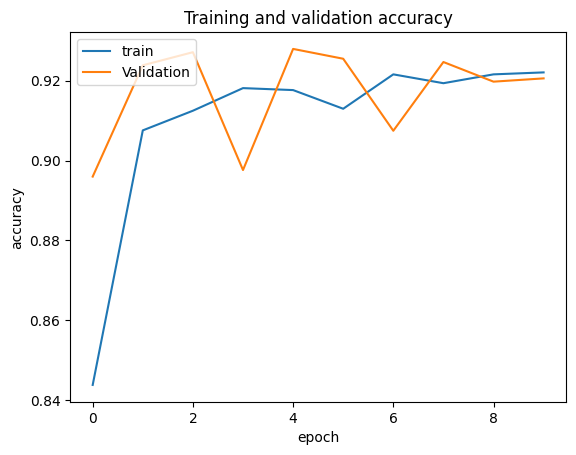

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
[[393  98   0]
 [ 75 457   0]
 [  0   3 534]]
0.8871794871794871
0.8871925154218614
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       491
           1       0.82      0.86      0.84       532
           2       1.00      0.99      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.88      0.89      1560
weighted avg       0.89      0.89      0.89      1560



<Axes: >

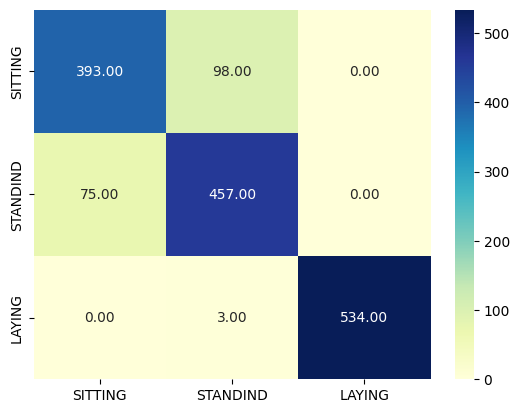

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_24 (LSTM)              (None, None, 100)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 6s 37ms/step - loss: 0.4490 - accuracy: 0.8097 - val_loss: 0.2246 - val_accuracy: 0.8845
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2213 - accuracy: 0.9044 - val_loss: 0.2051 - val_accuracy: 0.8968
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2100 - accuracy: 0.9117 - val_loss: 0.1943 - val_accuracy: 0.9034
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1978 - accuracy: 0.9125 - val_loss: 0.1888 - val_accuracy: 0.9107
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1959 - accuracy: 0.9120 - val_loss: 0.1841 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9139 - val_loss: 0.1821 - val_accuracy: 0.9206
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.9179 - val_loss: 0.1795 - val_accuracy: 0.9091
Epoch 8/10
32

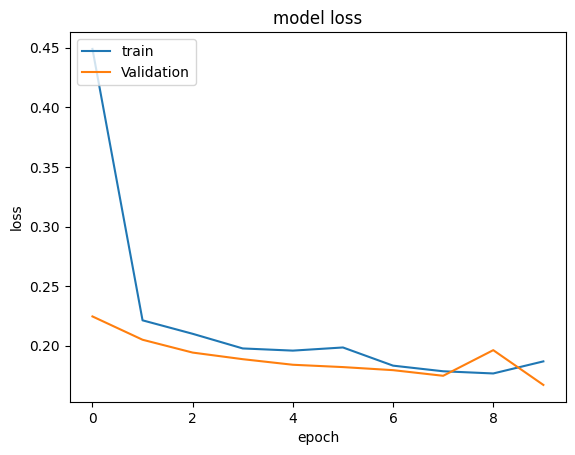

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

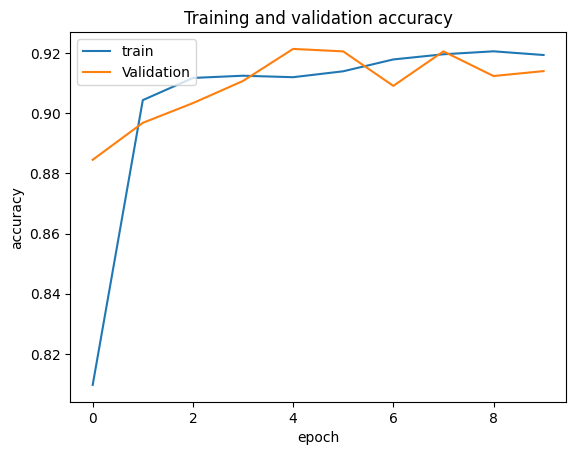

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[386 105   0]
 [ 82 450   0]
 [  0   1 536]]
0.8794871794871795
0.8793786047351476
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       491
           1       0.81      0.85      0.83       532
           2       1.00      1.00      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

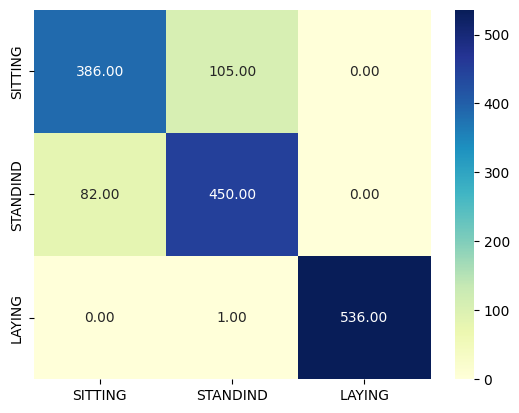

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2- LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 7s 31ms/step - loss: 0.4127 - accuracy: 0.8303 - val_loss: 0.2189 - val_accuracy: 0.8993
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2104 - accuracy: 0.9095 - val_loss: 0.2075 - val_accuracy: 0.9156
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2149 - accuracy: 0.9078 - val_loss: 0.2288 - val_accuracy: 0.8903
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2085 - accuracy: 0.9149 - val_loss: 0.2315 - val_accuracy: 0.9115
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2011 - accuracy: 0.9134 - val_loss: 0.1972 - val_accuracy: 0.9214
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1880 - accuracy: 0.9211 - val_loss: 0.1878 - val_accuracy: 0.9140
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.9211 - val_loss: 0.1891 - val_accuracy: 0.9156
Epoch 8/10
32/32 [=

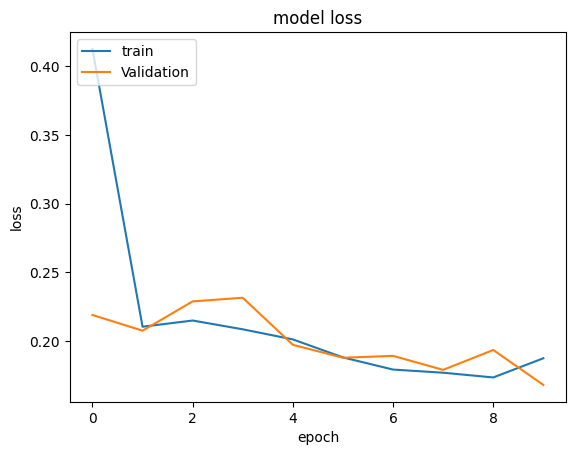

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

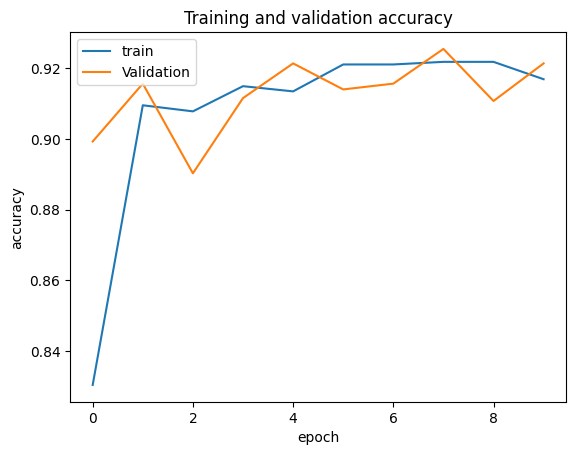

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[390 101   0]
 [ 90 442   0]
 [  0  27 510]]
0.8602564102564103
0.8617491082035287
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       491
           1       0.78      0.83      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

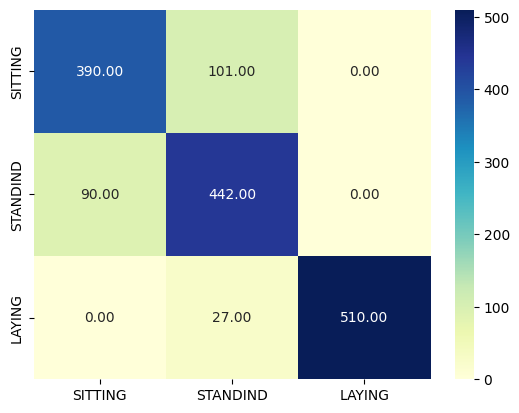

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 -LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 896)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 9s 36ms/step - loss: 0.4415 - accuracy: 0.8279 - val_loss: 0.2053 - val_accuracy: 0.9099
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2204 - accuracy: 0.9098 - val_loss: 0.1944 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2172 - accuracy: 0.9078 - val_loss: 0.2081 - val_accuracy: 0.9099
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2018 - accuracy: 0.9152 - val_loss: 0.1876 - val_accuracy: 0.9165
Epoch 5/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1934 - accuracy: 0.9117 - val_loss: 0.1937 - val_accuracy: 0.9075
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1860 - accuracy: 0.9176 - val_loss: 0.1867 - val_accuracy: 0.9099
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.9189 - val_loss: 0.1736 - val_accuracy: 0.9255
Epoch 8/10
32/3

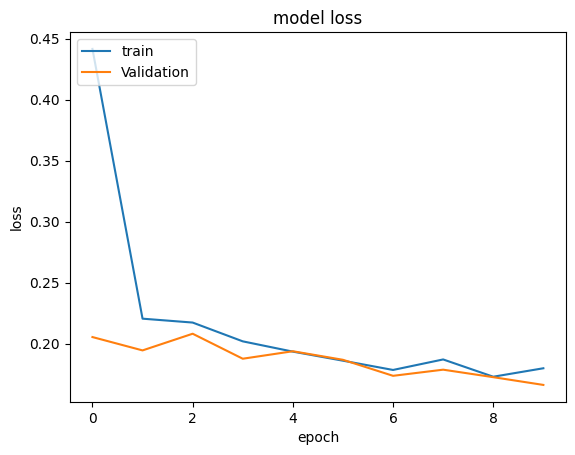

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

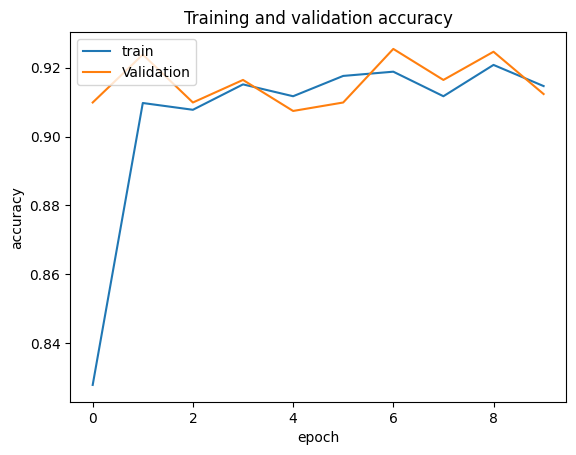

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[402  89   0]
 [101 431   0]
 [  0  27 510]]
0.860897435897436
0.8623763364156689
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       491
           1       0.79      0.81      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

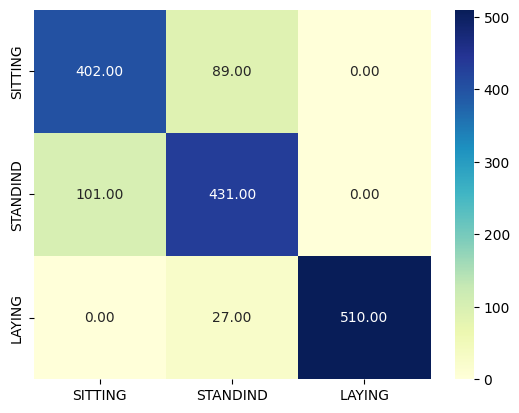

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')